사용할 분류 : 꼬꼬마(Kkma) , Okt , Mecab

사용할 모델 : LSTM(비교용) ,양방향 LSTM (Bi-LSTM)

도입해보고 그 결과 수치가 어느정도 차이 나는지 정도로 작성하기

Bi LSTM 관련 링크

이론 : https://wegonnamakeit.tistory.com/25

사용 예제 : https://wikidocs.net/94748


# 모듈 선언
가능하다면 작업 완료 후 전부 여기에 할당할것

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 1) 훈련 데이터 다운로드

In [2]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="./dataset/ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="./dataset/ratings_test.txt")

('./dataset/ratings_test.txt', <http.client.HTTPMessage at 0x150bfd90520>)

## 2. 데이터를 변수에 담아주기

In [3]:
train_data = pd.read_table('./dataset/ratings_train.txt')
test_data = pd.read_table('./dataset/ratings_test.txt')

## 3. 중복 확인

In [4]:
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

## 4. 중복 제거

In [5]:
train_data.drop_duplicates(subset=['document'], inplace=True)

In [6]:
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 146183


## 5. 리뷰 중에 Null 값을 가진 샘플이 있는지 확인

In [7]:
print(train_data.isnull().values.any())

True


True가 나왔다면 데이터 중에 Null 값을 가진 샘플이 존재한다는 의미

In [8]:
print(train_data.isnull().sum())

id          0
document    1
label       0
dtype: int64


## 6. Null 값을 가진 샘플을 제거

In [9]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [10]:
print(len(train_data))

146182


## 정규 표현식 수행

온점 같은 구두점들 제거

In [11]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

C:\Temp/ipykernel_17488/3198192014.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


공백만 있거나 빈 값이 있는 데이터 Null 처리 및 존재 확인

In [12]:
train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


C:\Temp/ipykernel_17488/1225369754.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "") # white space 데이터를 empty value로 변경


In [13]:
train_data.loc[train_data.document.isnull()].head()

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


Null값들 제거

In [14]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

145393


In [15]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 48852


C:\Temp/ipykernel_17488/2045415552.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
C:\Temp/ipykernel_17488/2045415552.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "") # 공백은 empty 값으로 변경


3만 : 1만의 3:1 비율로 샘플링

In [16]:
train_data = train_data.sample(n = 30000, random_state = 1)
test_data = test_data.sample(n = 10000, random_state = 1)

print('샘플링한 훈련 샘플 수 :',len(train_data))
print('샘플링한 테스트 샘플 수 :',len(test_data))

샘플링한 훈련 샘플 수 : 30000
샘플링한 테스트 샘플 수 : 10000


## 7) 토큰화

원문에서는 OKT를 사용했지만

추가적으로 꼬꼬마(Kkma),Mecab(은전한닢)을 사용해보도록 한다.

In [17]:
from konlpy.tag import Kkma
#from konlpy.jvm import init_jvm
kkma = Kkma()

sample_text = train_data.iloc[7, 1]

print('형태소 분석 :',kkma.morphs(sample_text))
print('품사 태깅 :',kkma.pos(sample_text))
print('명사 추출 :',kkma.nouns(sample_text))

형태소 분석 : ['조건', '과', '편리함', '만', '을', '따지', '는', '요즘', '세대', '들', '이', '진정', '하', 'ㄴ', '사랑이', '무엇', '이', 'ㄴ지', '보', '고', '배우', '어야', '하', 'ㄹ', '영화']
품사 태깅 : [('조건', 'NNG'), ('과', 'JKM'), ('편리함', 'NNG'), ('만', 'JX'), ('을', 'JKO'), ('따지', 'VV'), ('는', 'ETD'), ('요즘', 'NNG'), ('세대', 'NNG'), ('들', 'XSN'), ('이', 'JKS'), ('진정', 'NNG'), ('하', 'XSV'), ('ㄴ', 'ETD'), ('사랑이', 'NNG'), ('무엇', 'NNG'), ('이', 'VCP'), ('ㄴ지', 'ECD'), ('보', 'VV'), ('고', 'ECE'), ('배우', 'VV'), ('어야', 'ECD'), ('하', 'VV'), ('ㄹ', 'ETD'), ('영화', 'NNG')]
명사 추출 : ['조건', '편리함', '요즘', '요즘세대', '세대', '진정', '사랑이', '무엇', '영화']


In [18]:
init_jvm(jvmpath=None, max_heap_size='8192M')

불용어 지정

In [19]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [23]:
X_train = []

for sentence in tqdm(train_data['document']):
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_train.append(stopwords_removed_sentence)

 53%|█████▎    | 16048/30000 [10:04<08:45, 26.56it/s]  


java.lang.OutOfMemoryError: java.lang.OutOfMemoryError: Java heap space

kkma엔 Okt의 stem argument가 없음


In [24]:
# For Check
print(X_train[:3])

[['배경', '만', '볼만', '하', 'ㅁ'], ['여기', '전라도', '비하', '하', '인간', '같', '지', '않', '인간', '아', '아', '영화', '내용', '중요', '하', '지', '지역', '중요', '하', '냐', '그러', 'ㅁ', '공주', '에서', '밀양', '이야기', '안', '꺼내', 'ㄴ', '것', '어쩌', 'ㄹ', '것', 'ㄴ데', '아', '아', '자기', '내용', '나오', '아서', '움찔', '하', 'ㄴ', '거', '냐', '함부로', '떠들', 'ㄹ지', '마라'], ['이런', '영화', '좋', '다', '잔잔', '하', 'ㅁ', '속', '공감', '갈', '내용', '작품', '배우', '연기', '좋', '았', '다']]


테스트에도 동일하게 진행

In [25]:
X_test = []

for sentence in tqdm(test_data['document']):
    tokenized_sentence = kkma.morphs(sentence) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|██████████| 10000/10000 [03:52<00:00, 42.98it/s]


22.03.19 메모 (1)

heap 영역에 메모리 문제 발생

+)해결 : init_jvm() 변수로 메모리 할당 조정

토큰화를 하고 나면 또 하는 작업을 방지하고자 

데이터프레임으로 변환하고 csv로 저장하는걸 추천

차후 작업에 용이

In [26]:
pd.Series(X_train).to_csv('./dataset/kkma_x_train.csv',index=False)
pd.Series(X_test).to_csv('./dataset/kkma_x_test.csv',index=False)

## 정수 인코딩

In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [28]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 14788
등장 빈도가 2번 이하인 희귀 단어의 수: 9141
단어 집합에서 희귀 단어의 비율: 61.813632675142
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.479552797986005


등장 빈도수가 2 이하인 단어들의 수를 제외한 단어의 개수를 집합의 Max로 제한

In [29]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 5648


케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환

In [30]:
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [31]:
# For Check
print(X_train[:3])

[[591, 26, 428, 1, 21], [467, 2210, 634, 1, 302, 34, 14, 38, 302, 12, 12, 3, 72, 766, 1, 14, 2602, 766, 1, 89, 296, 21, 2397, 35, 138, 44, 2, 15, 559, 10, 15, 73, 12, 12, 581, 72, 50, 90, 1, 2, 49, 89, 3703, 3227, 341, 496], [69, 3, 19, 4, 451, 1, 21, 223, 317, 232, 72, 109, 70, 40, 19, 13, 4]]


train_data에서 y_train과 y_test를 별도로 저장

In [32]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

## 빈 샘플 제거

In [33]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [34]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

16029
29981


C:\Users\JW\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 6) 패딩

리뷰의 최대 길이 : 82
리뷰의 평균 길이 : 15.031255848774096


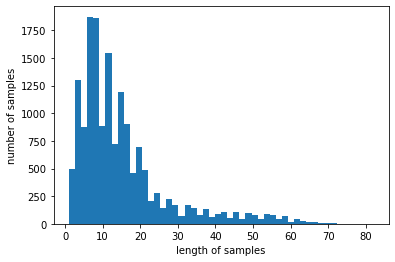

In [35]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [36]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인하는 함수
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [37]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 89.36926820138498


전체 샘플의 길이를 30으로 제한

In [38]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

# LSTM을 통한 감성 분류

최종 선정한 모델과의 정확도 비교를 위해 

원문에서 사용했던 LSTM모델을 활용

In [39]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model_result/LSTM_Best_Model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
201/201 [==============================] - 12s 40ms/step - loss: 0.5073 - acc: 0.7502 - val_loss: 0.4546 - val_acc: 0.8041

Epoch 00001: val_acc improved from -inf to 0.80412, saving model to ./model_result\LSTM_Best_Model.h5
Epoch 2/15
201/201 [==============================] - 8s 37ms/step - loss: 0.3708 - acc: 0.8360 - val_loss: 0.4424 - val_acc: 0.8026

Epoch 00002: val_acc did not improve from 0.80412
Epoch 3/15
201/201 [==============================] - 7s 37ms/step - loss: 0.3321 - acc: 0.8574 - val_loss: 0.4330 - val_acc: 0.8088

Epoch 00003: val_acc improved from 0.80412 to 0.80880, saving model to ./model_result\LSTM_Best_Model.h5
Epoch 4/15
201/201 [==============================] - 8s 37ms/step - loss: 0.3044 - acc: 0.8723 - val_loss: 0.4344 - val_acc: 0.8016

Epoch 00004: val_acc did not improve from 0.80880
Epoch 5/15
201/201 [==============================] - 7s 37ms/step - loss: 0.2812 - acc: 0.8854 - val_loss: 0.4297 - val_acc: 0.8075

Epoch 00005: val_acc d

In [40]:
loaded_model = load_model('./model_result/LSTM_Best_Model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 3s 9ms/step - loss: 0.4135 - acc: 0.8092

 테스트 정확도: 0.8092


# 리뷰 예측해보기

In [41]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = kkma.morphs(new_sentence) # 토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
  score = float(loaded_model.predict(pad_new)) # 예측
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [42]:
sentiment_predict('이 영화 개꿀잼 ㅋㅋㅋ')

92.86% 확률로 긍정 리뷰입니다.



# BiLSTM으로 분류하기

In [43]:
import re
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units))) # Bidirectional LSTM을 사용
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('./model_result/BiLSTM_Best_Model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=256, validation_split=0.2)

Epoch 1/15
51/51 [==============================] - 14s 164ms/step - loss: 0.5510 - acc: 0.7160 - val_loss: 0.5544 - val_acc: 0.7480

Epoch 00001: val_acc improved from -inf to 0.74797, saving model to ./model_result\BiLSTM_Best_Model.h5
Epoch 2/15
51/51 [==============================] - 7s 140ms/step - loss: 0.3937 - acc: 0.8288 - val_loss: 0.4528 - val_acc: 0.8060

Epoch 00002: val_acc improved from 0.74797 to 0.80599, saving model to ./model_result\BiLSTM_Best_Model.h5
Epoch 3/15
51/51 [==============================] - 7s 134ms/step - loss: 0.3330 - acc: 0.8610 - val_loss: 0.8105 - val_acc: 0.6984

Epoch 00003: val_acc did not improve from 0.80599
Epoch 4/15
51/51 [==============================] - 7s 133ms/step - loss: 0.3133 - acc: 0.8712 - val_loss: 0.5209 - val_acc: 0.7402

Epoch 00004: val_acc did not improve from 0.80599
Epoch 5/15
51/51 [==============================] - 7s 130ms/step - loss: 0.2838 - acc: 0.8858 - val_loss: 0.5487 - val_acc: 0.7957

Epoch 00005: val_acc di

In [44]:
loaded_model = load_model('./model_result/BiLSTM_Best_Model.h5')
print("테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

313/313 [==============================] - 4s 11ms/step - loss: 0.4302 - acc: 0.8053
테스트 정확도: 0.8053


In [45]:
sentiment_predict('조금 어렵지만 재밌음ㅋㅋ')

98.23% 확률로 긍정 리뷰입니다.



## **0319 작업 기록 메모**
데이터를 원본 그대로 쓰지 않고 줄여놨더니 문제 발생

원인 : x와 y의 사이즈가 맞지 않음

추측 : LSTM이 다대일인데 X가 Y보다 적어서 발생한 것으로 추정

팀 회의에선 3만개로 줄이기로 제안했지만

5만개로 변경해보고 진행

이래도 안될 경우 데스크탑에서 원본 그대로 해보기로 진행